In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

import tensorflow as tf
import pickle
import os
import glob
import random
import sys
import datetime
import wispy
import wispy.resnet
import wispy.logger
import wispy.utils
import wispy.callbacks
import wispy.model_utils
from tomlkit import parse
from tensorflow.keras.utils import get_custom_objects
import pugna.activations

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

2021-09-14 02:02:23.950977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-14 02:02:23.951012: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
sys.path.append("../../")

In [7]:
import fit

In [8]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [9]:
%matplotlib inline

In [10]:
glob.glob("009/checkpoint/*")[-1]

'009/checkpoint/cp-04500.ckpt'

In [11]:
config_file = "config_009.toml"

In [12]:
model = tf.keras.models.load_model('009/checkpoint/cp-04500.ckpt',
                                   custom_objects={'ScaleLayer': wispy.mscalev3.ScaleLayer}
                                  )

2021-09-14 02:02:35.133496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-14 02:02:35.133554: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-14 02:02:35.133582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev5): /proc/driver/nvidia/version does not exist
2021-09-14 02:02:35.133961: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
with open(config_file, "r") as f:
    text = f.read()

doc = parse(text)

In [14]:
doc['data']['train_root_dir']

'/home/sebastian.khan/data/wispy/aug2021/test-8d-1e6/training_data'

In [15]:
doc['data']['data_to_model']

'amps'

In [16]:
filename = doc['data']['y_preprocessing_params_file']
y_processing_params = np.load(filename)

In [17]:
# y_train = fit.load_coprec_data_and_apply_preproc(doc['data']['train_root_dir'], doc['data']['data_to_model'], y_processing_params)
# y_train = fit.load_coprec_data_and_apply_preproc(doc['data']['val_root_dir'], doc['data']['data_to_model'], y_processing_params)

y_train_22 = fit.load_coprec_data_and_apply_preproc(doc['data']['val_root_dir'], "amp_22", y_processing_params)
y_train_21 = fit.load_coprec_data_and_apply_preproc(doc['data']['val_root_dir'], "amp_21", y_processing_params)

In [18]:
y_train_22.shape

(1000, 1219)

In [19]:
filename = doc['data']['times_file']
times = np.load(filename)

pkl_filename = doc['data']['times_scaler']
with open(pkl_filename, 'rb') as file:
    times_scaler = pickle.load(file)

times_scaled = times_scaler.transform(times[:, np.newaxis])

/home/sebastian.khan/.conda/envs/wispy/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


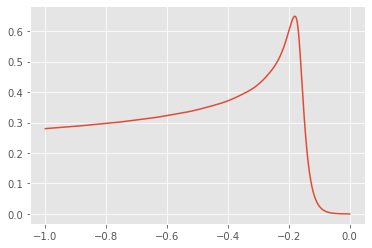

In [20]:
plt.figure()
plt.plot(times_scaled, y_train_22[0])

In [21]:
# filename = doc['data']['coords_train_file']
filename = doc['data']['coords_val_file']
coords_train = np.load(filename).T

In [22]:
def get_input_for_ann(times, coords):
    return np.column_stack((times[:, 0], (coords*np.ones(times.shape))))

In [23]:
X = get_input_for_ann(times_scaled, coords_train[0])

In [24]:
X.shape

(1219, 8)

In [25]:
coords_train.shape

(1000, 7)

In [26]:
model.predict(X)[:,0]

2021-09-14 02:02:39.503749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([2.8016725e-01, 2.8022596e-01, 2.8028512e-01, ..., 8.1032515e-05,
       7.2449446e-05, 6.3031912e-05], dtype=float32)

In [27]:
def compare_amp22(index, model, times_scaled, coords, y_train):
    print(coords[index])
    X = get_input_for_ann(times_scaled, coords[index])
    yhat = model.predict(X)[:,0]
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(times_scaled, y_train[index], label='data')
    plt.plot(times_scaled, yhat, label='model')
    plt.title("amp 22")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(times_scaled, y_train[index]-yhat)
    plt.show()
    plt.close()

In [28]:
def compare_amp21(index, model, times_scaled, coords, y_train):
    print(coords[index])
    X = get_input_for_ann(times_scaled, coords[index])
    yhat = model.predict(X)[:,1]
    
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(times_scaled, y_train[index], label='data')
    plt.plot(times_scaled, yhat, label='model')
    plt.title("amp 21")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(times_scaled, y_train[index]-yhat)
    plt.show()
    plt.close()

[3.52966636 0.43513474 1.25762855 3.39978665 0.38097022 2.57325398
 5.5918269 ]


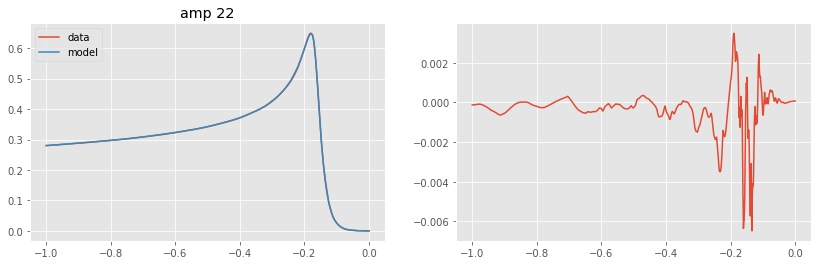

In [33]:
compare_amp22(0, model, times_scaled, coords_train, y_train_22)

[3.52966636 0.43513474 1.25762855 3.39978665 0.38097022 2.57325398
 5.5918269 ]


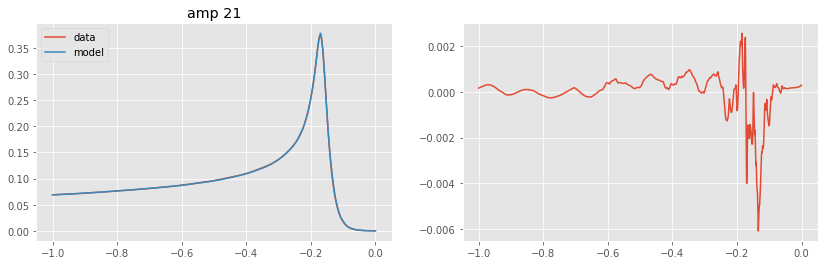

In [34]:
compare_amp21(0, model, times_scaled, coords_train, y_train_21)

158
[1.14962075 0.31151095 0.83841597 3.53652886 0.79457534 0.1557885
 4.07488573]


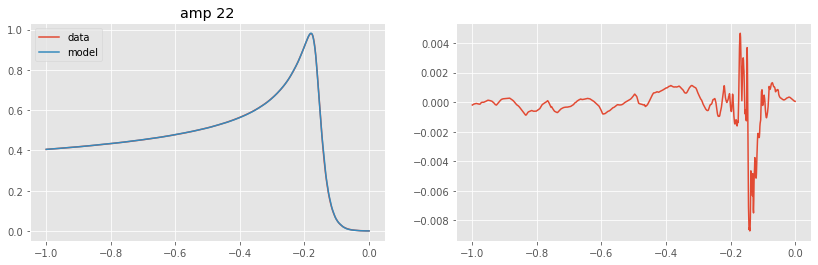

850
[3.03094651 0.94602533 1.83826351 0.06201345 0.32781767 0.72273461
 5.75212792]


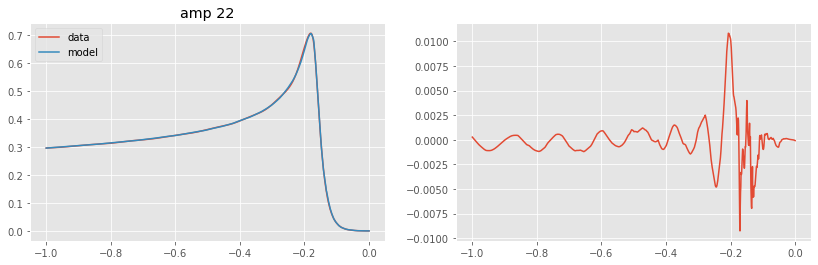

340
[3.71841682 0.07968427 1.71185633 0.98430616 0.80607247 1.24191048
 3.67216845]


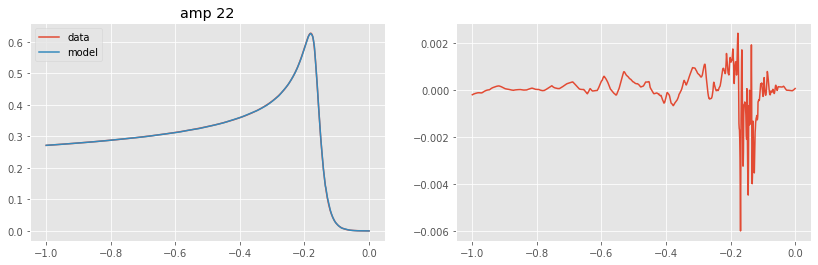

38
[1.27696772 0.88534593 0.84301607 2.26328189 0.66845698 2.48203642
 3.25578562]


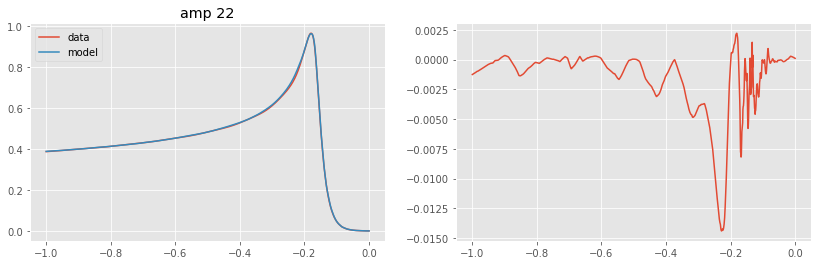

531
[2.56045376 0.80380023 1.88446112 4.080844   0.36756338 0.84276157
 4.40155216]


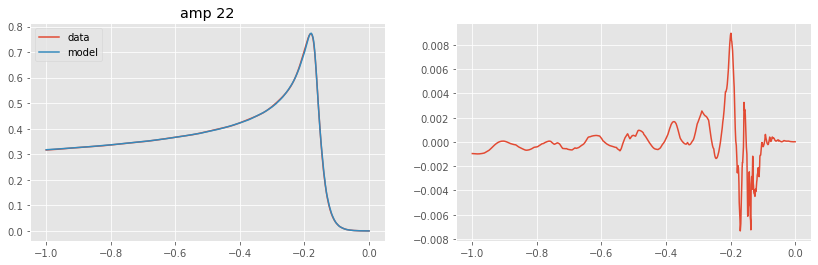

955
[2.55826736 0.0604599  2.04713576 1.53312029 0.54427175 1.95454557
 3.89057615]


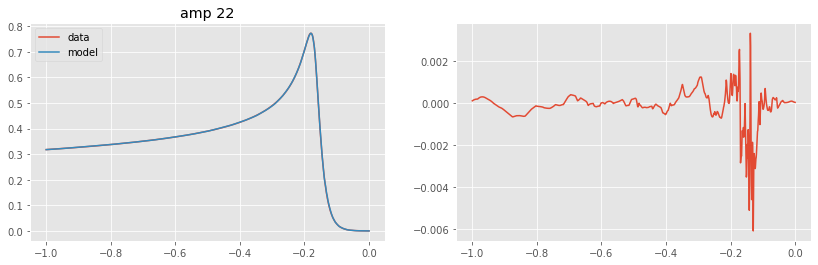

30
[2.61364816 0.18562569 2.07322447 1.58026691 0.05981995 1.66131836
 2.11260336]


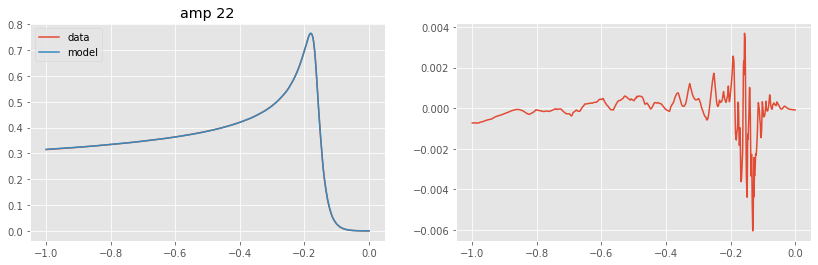

842
[3.95623943 0.35882199 1.89562178 2.61746707 0.53930706 0.7995694
 3.62804021]


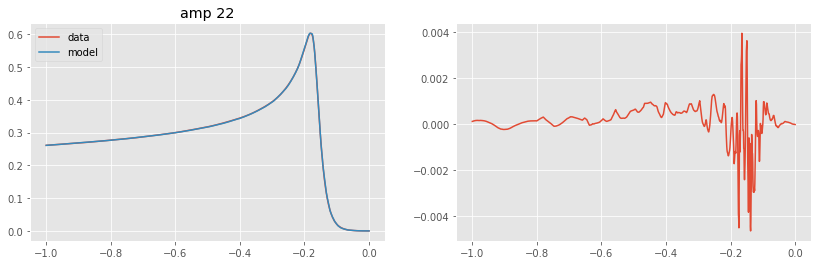

493
[1.86796316 0.20862673 1.5443561  5.64270072 0.28949543 1.22197405
 4.21301117]


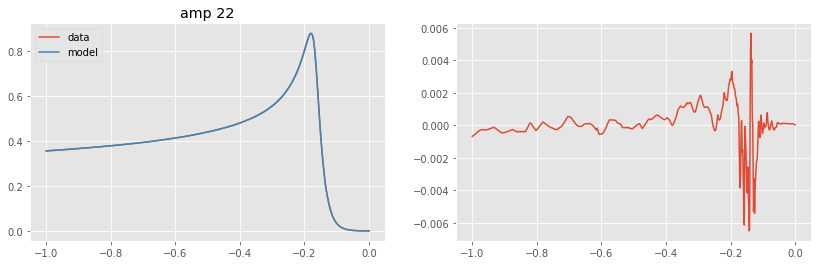

622
[1.4771904  0.65649148 2.81625463 3.98922239 0.10959567 1.73305058
 5.53400735]


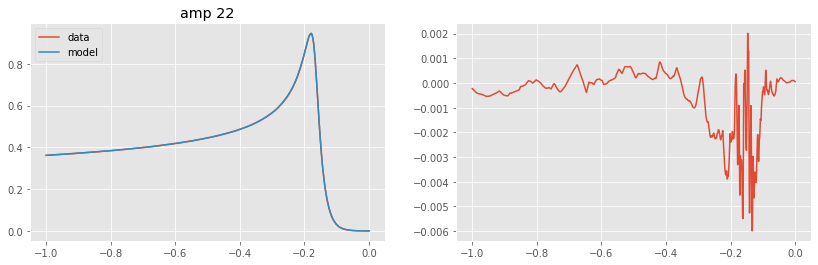

In [35]:
for i in random.sample(range(len(coords_train)), 10):
    print(i)
    compare_amp22(i, model, times_scaled, coords_train, y_train_22)

105
[1.34285446 0.62747441 0.83158089 2.07974282 0.16598562 1.30502308
 6.24392854]


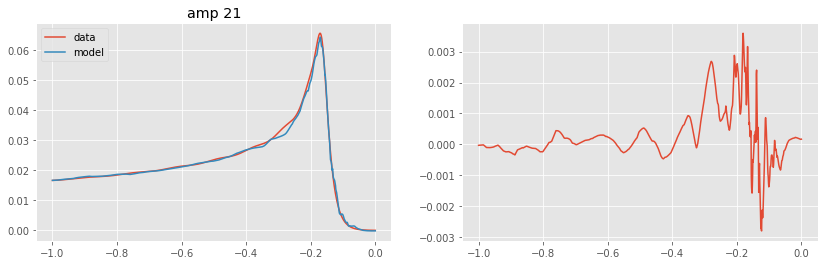

448
[3.56183919 0.24033228 2.79700392 1.00944263 0.6255602  1.67685708
 0.04104561]


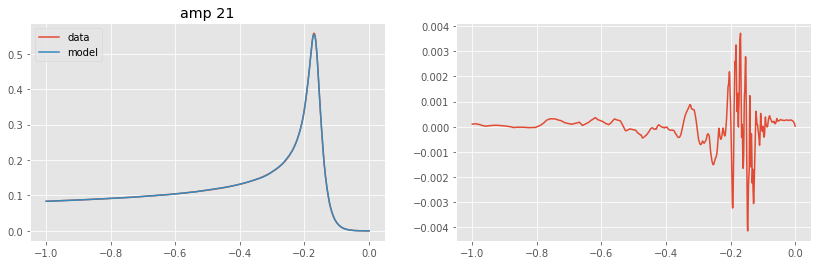

548
[2.67611575 0.56573645 2.00552167 5.5571695  0.92493342 0.03929511
 0.34587814]


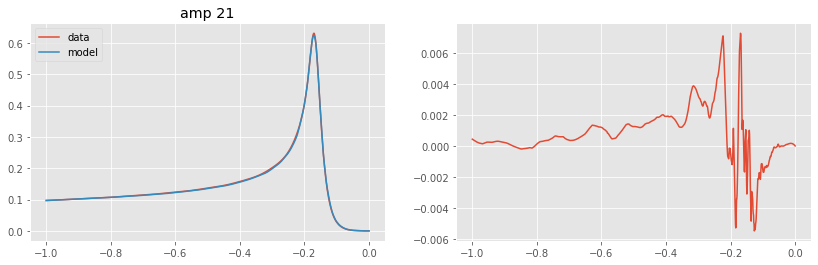

633
[1.29139021 0.4109443  0.60326589 4.57495212 0.93803898 2.07041849
 5.28651717]


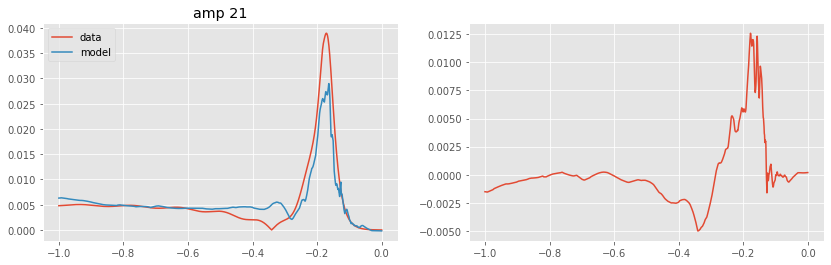

741
[2.65883783 0.88558056 0.76958748 0.8659144  0.44996498 2.32979953
 0.62012293]


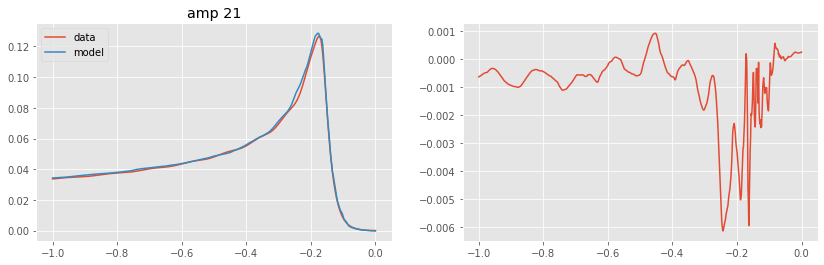

495
[1.15322352 0.10644299 1.8137991  3.46953489 0.75518142 1.95531517
 0.90983698]


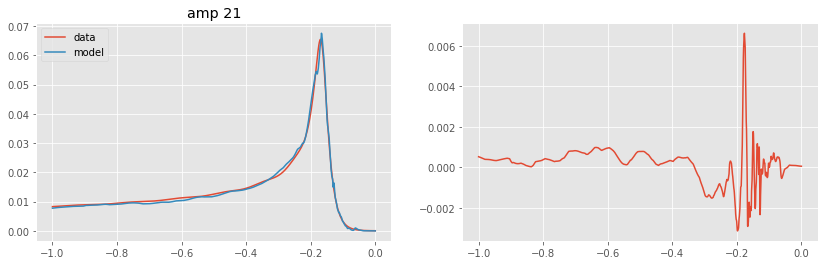

122
[1.91748337 0.81584735 0.95522599 5.55580206 0.91969323 0.92147583
 2.99685957]


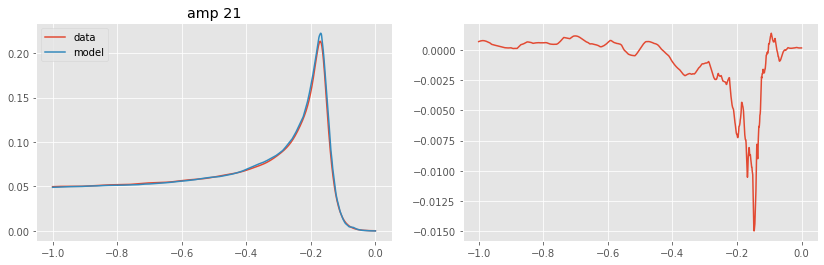

663
[2.0186039  0.32440551 2.3112341  1.09938113 0.79068454 1.60708268
 0.84967366]


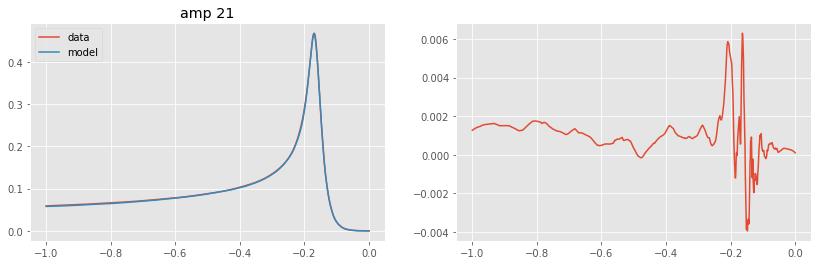

272
[3.55280686 0.38051621 2.0218733  4.91225705 0.50799188 1.04563979
 5.47035614]


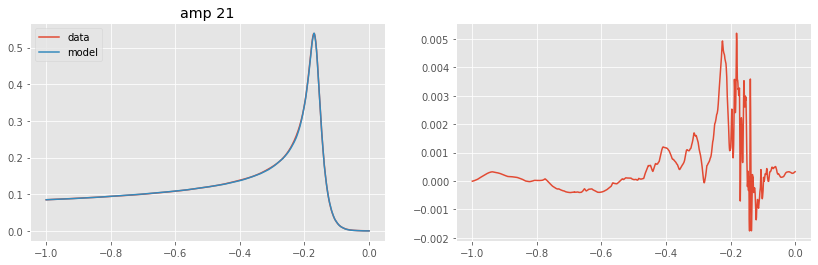

497
[1.78978461 0.09584706 1.33593944 5.31197258 0.04397285 1.32686738
 5.87923186]


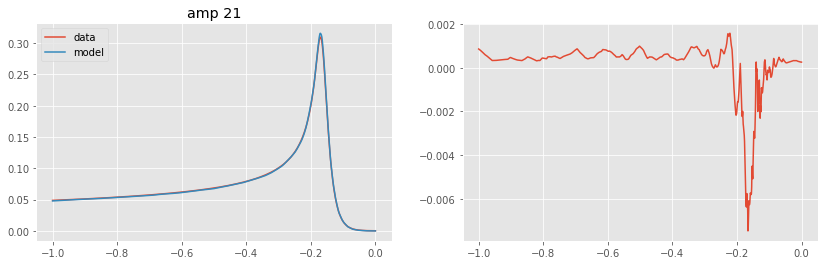

In [37]:
for i in random.sample(range(len(coords_train)), 10):
    print(i)
    compare_amp21(i, model, times_scaled, coords_train, y_train_21)